# ¿Qué patrones existen entre consumo y generación de energía?

**Contexto de negocios.**
Eres un analista de una planta de energía y responsable por encontrar patrones en la generación de energía eléctrica, y el consumo de esta a través de diferentes sectores de Estados Unidos.

**Problema de negocios** **"¿Cómo deberían de asignarse los recursos de generación de energía, dada su relación con el consumo en los diferentes sectores a través del tiempo?"**

**Contexto analítico.** 
Datos en formato CSV por sector. Es necesario preprocesar la información y transformarla en un formato adecuado, graficar para explorar relaciones, identificar patrones a lo largo del tiempo y utilizar funcionalidades avanzadas para graficar.

In [1]:
# Paquetes
import os
import pandas as pd
import numpy as np

# Mostrar gráficos dentro del cuaderno de Jupyter
%matplotlib inline

# Gráficos inspirados en MatLab
import matplotlib.pyplot as plt

# Requerido para formatear datos con fechas
import datetime
import matplotlib.dates as mdates

# Mostrar imágenes en el cuaderno
from IPython.display import Image

# Paquete para gráficos avanzados
import seaborn as sns
sns.set(style="whitegrid") # Estilo del gráfico

## Energy Information Administration (EIA)

Consumo mensual ```energy_consumption.csv``` y generación mensual ```electricity_generation.csv```.

### energy_consumption.csv
- Consumo mensual por sector en U.S.
- La energía total por sector consiste en consumo primario, ventas al por menor de electricidad y pérdidas de sistemas energéticos.

### electricity_generation.csv
- Generación mensual de energía.
- La generación de energía neta es la generación bruta de energía menos el uso que hace la estación
- Btu = British Thermal Unit

(Fuente: https://www.eia.gov/totalenergy/data/monthly/pdf/sec13.pdf)

Cargar los datos:

In [2]:
# Cargar los datos
energy_consumption_file = os.path.join(os.getcwd(),'energy_consumption.csv')       
electricity_generation_file = os.path.join(os.getcwd(),'electricity_generation.csv')

energy_df = pd.read_csv(energy_consumption_file)
electricity_df = pd.read_csv(electricity_generation_file)

In [3]:
# Consumo de energía
energy_df.head()

,YYYYMM,Value,Description,Unit
0,197301,1313.816,Primary Energy Consumed by the Residential Sector,Trillion Btu
1,197302,1150.011,Primary Energy Consumed by the Residential Sector,Trillion Btu
2,197303,970.362,Primary Energy Consumed by the Residential Sector,Trillion Btu
3,197304,709.631,Primary Energy Consumed by the Residential Sector,Trillion Btu
4,197305,544.596,Primary Energy Consumed by the Residential Sector,Trillion Btu


In [4]:
# Descripciones únicas
print(energy_df['Description'].unique())

['Primary Energy Consumed by the Residential Sector'
 'Total Energy Consumed by the Residential Sector'
 'Primary Energy Consumed by the Commercial Sector'
 'Total Energy Consumed by the Commercial Sector'
 'Primary Energy Consumed by the Industrial Sector'
 'Total Energy Consumed by the Industrial Sector'
 'Primary Energy Consumed by the Transportation Sector'
 'Total Energy Consumed by the Transportation Sector'
 'Primary Energy Consumed by the Electric Power Sector'
 'Primary Energy Consumption Total']


In [5]:
# Generación de energía
electricity_df.head()

,YYYYMM,Value,Description,Unit
0,197301,75190.149,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
1,197302,67797.946,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
2,197303,67387.612,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
3,197304,63935.049,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
4,197305,64927.181,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours


In [6]:
# Descripciones únicas
print(electricity_df['Description'].unique())

['Electricity Net Generation From Coal, All Sectors'
 'Electricity Net Generation From Petroleum, All Sectors'
 'Electricity Net Generation From Natural Gas, All Sectors'
 'Electricity Net Generation From Other Gases, All Sectors'
 'Electricity Net Generation From Nuclear Electric Power, All Sectors'
 'Electricity Net Generation From Hydroelectric Pumped Storage, All Sectors'
 'Electricity Net Generation From Conventional Hydroelectric Power, All Sectors'
 'Electricity Net Generation From Wood, All Sectors'
 'Electricity Net Generation From Waste, All Sectors'
 'Electricity Net Generation From Geothermal, All Sectors'
 'Electricity Net Generation From Solar, All Sectors'
 'Electricity Net Generation From Wind, All Sectors'
 'Electricity Net Generation Total, All Sectors']


Hay varios sectores y fuentes de energía, pero solo nos interesa el de generación nuclear para el sector eléctrico

## Preprocesar los datos

La columna ```YYYYMM``` para el mes y año es difícil de usar, así que vamos a dividirla:

In [7]:
# Extraer el mes
energy_df['MM'] = energy_df['YYYYMM'].apply(lambda x: int(str(x)[-2:]))
electricity_df['MM'] = electricity_df['YYYYMM'].apply(lambda x: int(str(x)[-2:]))

# Extraer año
energy_df['YYYY'] = energy_df['YYYYMM'].apply(lambda x: int(str(x)[:-2]))
electricity_df['YYYY'] = electricity_df['YYYYMM'].apply(lambda x: int(str(x)[:-2]))

Algunas abreviaciones

- PEC: Primary Energy Consumption
- TEC: Total Energy Consumption
- ENG: Electricity Net Generation

Así, utilicemos la abreviación para ```Description``` lo cual será práctico cuando queramos graficar

In [9]:
# Renombrar para energía
energy_short_dict = {'Primary Energy Consumed by the Commercial Sector': 'PEC Commercial Sector',
              'Primary Energy Consumed by the Electric Power Sector': 'PEC Electric Power Sector',
              'Primary Energy Consumed by the Industrial Sector': 'PEC Industrial Sector',
              'Primary Energy Consumed by the Residential Sector': 'PEC Residential Sector',
              'Primary Energy Consumed by the Transportation Sector': 'PEC Transportation Sector',
              'Primary Energy Consumption Total': 'PEC Total',
              'Total Energy Consumed by the Commercial Sector': 'TEC Commercial Sector',
              'Total Energy Consumed by the Industrial Sector': 'TEC Industrial Sector',
              'Total Energy Consumed by the Residential Sector': 'TEC Residential Sector',
              'Total Energy Consumed by the Transportation Sector': 'TEC Transportation Sector'}

# Limpieza de los nombres acortándolos
clean_energy_df = energy_df.copy()
clean_energy_df['Description'] = clean_energy_df['Description'].apply(lambda x: energy_short_dict[x])
clean_energy_df.head()

,YYYYMM,Value,Description,Unit,MM,YYYY
0,197301,1313.816,PEC Residential Sector,Trillion Btu,1,1973
1,197302,1150.011,PEC Residential Sector,Trillion Btu,2,1973
2,197303,970.362,PEC Residential Sector,Trillion Btu,3,1973
3,197304,709.631,PEC Residential Sector,Trillion Btu,4,1973
4,197305,544.596,PEC Residential Sector,Trillion Btu,5,1973


In [10]:
# Renombrar para consumo
electricity_short_dict = {'Electricity Net Generation From Coal, All Sectors': 'ENG Coal',
                          'Electricity Net Generation From Conventional Hydroelectric Power, All Sectors': 'ENG HE Power',
                          'Electricity Net Generation From Geothermal, All Sectors': 'ENG Geothermal',
                          'Electricity Net Generation From Hydroelectric Pumped Storage, All Sectors': 'ENG HE Pumped Storage',
                          'Electricity Net Generation From Natural Gas, All Sectors': 'ENG Natural Gas',
                          'Electricity Net Generation From Nuclear Electric Power, All Sectors': 'ENG Nuclear Electric Power',
                          'Electricity Net Generation From Other Gases, All Sectors': 'ENG Other Gases',
                          'Electricity Net Generation From Petroleum, All Sectors': 'ENG Petroleum',
                          'Electricity Net Generation From Solar, All Sectors': 'ENG Solar',
                          'Electricity Net Generation From Waste, All Sectors': 'ENG Waste',
                          'Electricity Net Generation From Wind, All Sectors': 'ENG Wind',
                          'Electricity Net Generation From Wood, All Sectors': 'ENG Wood',
                          'Electricity Net Generation Total, All Sectors': 'ENG Total'}

# Limpiar...
clean_electricity_df = electricity_df.copy()
clean_electricity_df['Description'] = clean_electricity_df['Description'].apply(lambda x: electricity_short_dict[x])
clean_electricity_df.head()

,YYYYMM,Value,Description,Unit,MM,YYYY
0,197301,75190.149,ENG Coal,Million Kilowatthours,1,1973
1,197302,67797.946,ENG Coal,Million Kilowatthours,2,1973
2,197303,67387.612,ENG Coal,Million Kilowatthours,3,1973
3,197304,63935.049,ENG Coal,Million Kilowatthours,4,1973
4,197305,64927.181,ENG Coal,Million Kilowatthours,5,1973


Con los datos en un formato mejor, procedamos a graficar para ver si encontramos patrones:

## Identificando la relación entre consumo y generación de energía

El objetivo es cómo ubicar los recursos de acuerdo a patrones encontrados, para ello utilizaremos el paquete por defecto de python que realiza graficos. Como queremos ver una relación entre dos variables un diagrama de dispersión en 2 dimensiones es ideal.

In [11]:
# Categorías de consumo y generación
consume_category = 'PEC Electric Power Sector'
generate_category = 'ENG Nuclear Electric Power'

# Consumo del Sector eléctrico
consume_df = clean_energy_df[clean_energy_df['Description'] == consume_category][['YYYYMM','Value']].reset_index(drop=True)

# Consumo de energía nuclear para todos los sectores
generate_df = clean_electricity_df[clean_electricity_df['Description'] == generate_category][['YYYYMM','Value']].reset_index(drop=True)

# Combinar en un solo dataframe
merged_df = pd.merge(consume_df, generate_df, how='left', on=['YYYYMM'], suffixes=('_CONSUME','_GENERATE'))

merged_df.head()

,YYYYMM,Value_CONSUME,Value_GENERATE
0,197301,1691.096,6246.251
1,197302,1511.458,5928.069
2,197303,1559.159,6649.007
3,197304,1470.152,5876.392
4,197305,1551.631,5696.657


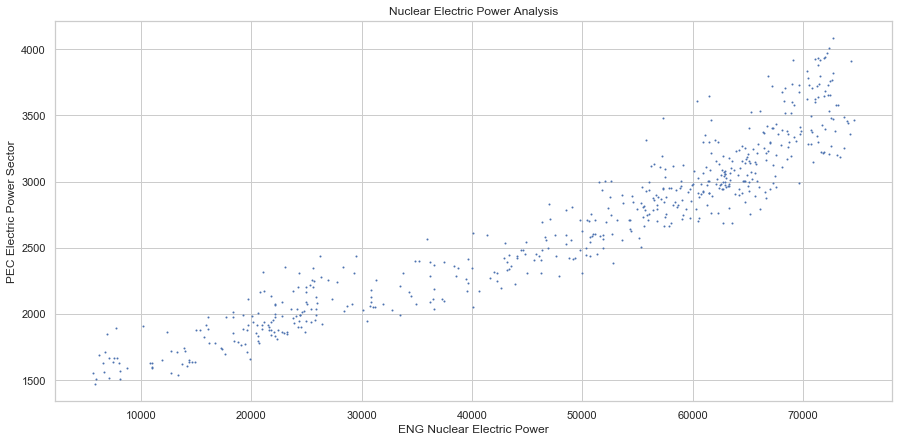

In [17]:
# Dispersión
plt.figure(figsize=(15, 7))
plt.scatter(merged_df['Value_GENERATE'], merged_df['Value_CONSUME'], s=1)
plt.title('Nuclear Electric Power Analysis');
plt.xlabel(generate_category);
plt.ylabel(consume_category);

### Ejercicio 1:
Como el ejemplo anterior, en lugar de generar el gráfico para el sector elétrico vs la energía nuclear, grafique un diagrama de dispersión para el sector comercial vs la energía nuclear. ¿Es la relación entre estas 2 variables más fuerte o más débil? 

**Respuesta.** Pista: es el mismo código anterior con un cambio. Utilice el nombre reducido del sector solicitado.

## Tendencias en generación y consumo de energía a través del tiempo

Gráfico de línea es más adecuado para ver tendencias en datos de series de tiempo.

In [39]:
consume_category = 'PEC Electric Power Sector'
generate_category = 'ENG Nuclear Electric Power'

# Sector eléctrico
consume_df = clean_energy_df[clean_energy_df['Description'] == consume_category][['YYYYMM','Value']].reset_index(drop=True)

# Electricidad generada por todos los sectores
generate_df = clean_electricity_df[clean_electricity_df['Description'] == generate_category][['YYYYMM','Value']].reset_index(drop=True)

# Combinar dataframes
merged_df = pd.merge(consume_df, generate_df, how='left', on=['YYYYMM'], suffixes=('_CONSUME','_GENERATE'))

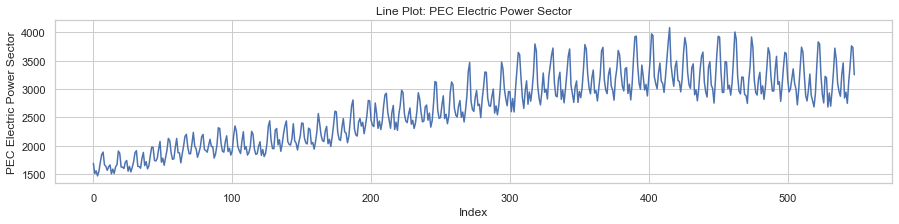

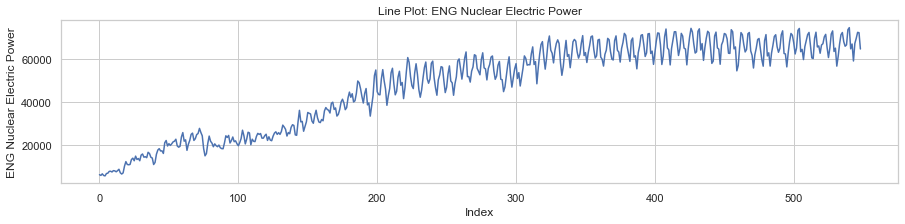

In [40]:
# Gráfico de línea para consumo de energía a través del tiempo
plt.figure(figsize=(15,3))
plt.plot(merged_df['Value_CONSUME'])
plt.title('Line Plot: ' + consume_category)
plt.xlabel('Index');
plt.ylabel(consume_category);

# Gráfico de línea para generación de energía a través del tiempo
plt.figure(figsize=(15,3))
plt.plot(merged_df['Value_GENERATE'])
plt.title('Line Plot: ' + generate_category)
plt.xlabel('Index');
plt.ylabel(generate_category);

Ambas se incrementan a través del tiempo, con tendencia cíclica fuerte, evidenciada por la naturaleza de las oscilaciones de la serie. Nótese que el eje x no está formateado adecuadamente como fecha.

### Mejorando la visualización de series de tiempo formateando las fechas

In [41]:
# Convertir string YYYYMM en formato datetime
merged_df['YYYYMM_dt'] = merged_df['YYYYMM'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m"))
merged_df.head()

,YYYYMM,Value_CONSUME,Value_GENERATE,YYYYMM_dt
0,197301,1691.096,6246.251,1973-01-01
1,197302,1511.458,5928.069,1973-02-01
2,197303,1559.159,6649.007,1973-03-01
3,197304,1470.152,5876.392,1973-04-01
4,197305,1551.631,5696.657,1973-05-01


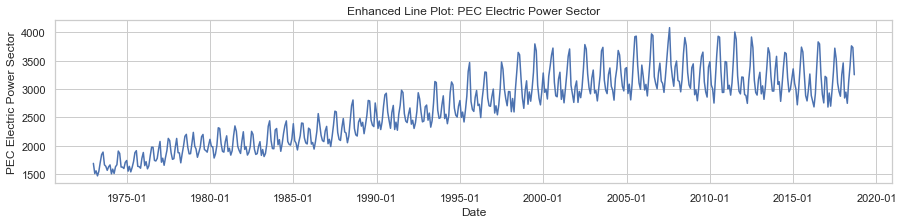

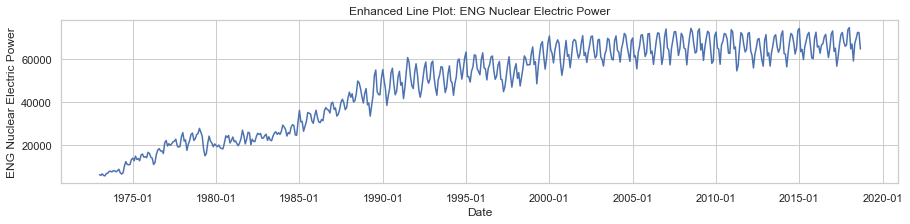

In [42]:
# Gráfico de consumo a través del tiempo mejorado
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(merged_df['YYYYMM_dt'], merged_df['Value_CONSUME'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # formatear eje x
plt.title('Enhanced Line Plot: ' + consume_category)
plt.xlabel('Date');
plt.ylabel(consume_category);

# Gráfico de energía a través del tiempo mejorado
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(merged_df['YYYYMM_dt'], merged_df['Value_GENERATE'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # formatear eje x
plt.title('Enhanced Line Plot: ' + generate_category)
plt.xlabel('Date');
plt.ylabel(generate_category);

### Ejercicio 2:

Escribe código que determine si las oscilaciones de la variable ```PEC Electric Power Sector```  para el consumo están creciendo a lo largo del tiempo.

**Respuesta.** Pista: es el mismo código anterior pero utilice ```merged_df['Value_CONSUME'].pct_change()```

El porcentaje de cambios no aumenta significativamente a través del tiempo. Esto indica que las fluctuaciones de energía se mantienen relativamente constantes, incluso si el uso total de energía ha aumentado.

Una herramienta para entender mejor la relación entre generación y consumo relativo es utilizar la tasa de consumo con respecto a energía generada. Así, se podría obtener indicios sobre el encuentro entre oferta y demanda para saber cómo la planta de energía se tiene que expandir de acuerdo a periodos de baja o alta demanda.


## Analizando la tasa de energía consumida sobre energía generada
Usaremos pandas y el método ```describe()``` para observar la distribución de esta tasa. Entender esta distribución es entender cómo las variables interactúan. 

In [44]:
# Crear columna 'Ratio'
merged_df['Ratio'] = merged_df['Value_CONSUME'] / merged_df['Value_GENERATE']
merged_df['MM'] = merged_df['YYYYMM'].apply(lambda x: int(str(x)[-2:])) # Agregar mes para agrupar en gráfico de caja
merged_df['Ratio'].describe()

count    549.000000
mean       0.067657
std        0.037364
min        0.042228
25%        0.048509
50%        0.052726
75%        0.076986
max        0.272376
Name: Ratio, dtype: float64

La representación gráfica de una distribución es un histograma, y lo podemos graficar utilizando el método ```plt.hist()```. El histograma toma el argumento ```bin``` que indica la granularidad a visualizarse. En este caso usaremos 50.

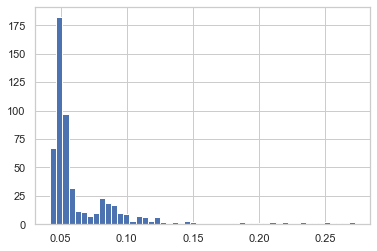

In [45]:
plt.hist(merged_df['Ratio'], bins=50);

La tasa se aglomera alrededor de 0.05. Un gráfico que toma en cuenta la distribución y los estadísticos descriptivos es el **diagrama de cajas**. Estos permiten observar valores extremos e inferir si los datos tienen alta varianza o están sesgados.

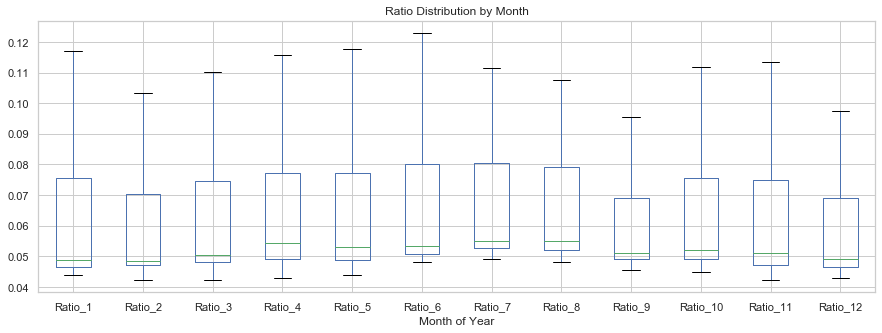

In [46]:
# Meses a utilizar
unique_months = [1,2,3,4,5,6,7,8,9,10,11,12]

# iterar sobre todos los meses y guardar los dataframes en una lista
df_list = []
for month_int in unique_months:
    temp_df = merged_df[merged_df['MM'] == month_int][['Ratio']].reset_index(drop=True) # Select month
    temp_df = temp_df.rename(columns={'Ratio':'Ratio_'+str(month_int)}) # rename for ease of plotting
    df_list.append(temp_df)

# Agregar los datos
plot_df = pd.concat(df_list, axis=1)

# Gráfico de caja
fig, ax = plt.subplots(figsize=(15,5))
plot_df.boxplot(ax=ax, showfliers=False)
ax.set_xlabel('Month of Year');
ax.set_title('Ratio Distribution by Month');

Mayor tasa durante los meses del verano, sobre todo julio(7) y agosto(8)

### Ejercicio 3:

¿Por qué se produce lo anterior?

**Respuesta.**

Ahora utilicemos el paquete seaborn.

## Usar ```seaborn``` para visualizar patrones cíclicos

Para explorar los meses identificados, los etiquetamos en ```merged_df``` y utilizar ```pairplot()``` para graficar las diferencias en la distribución de consumo y generación entre los meses de pico y los no-pico.

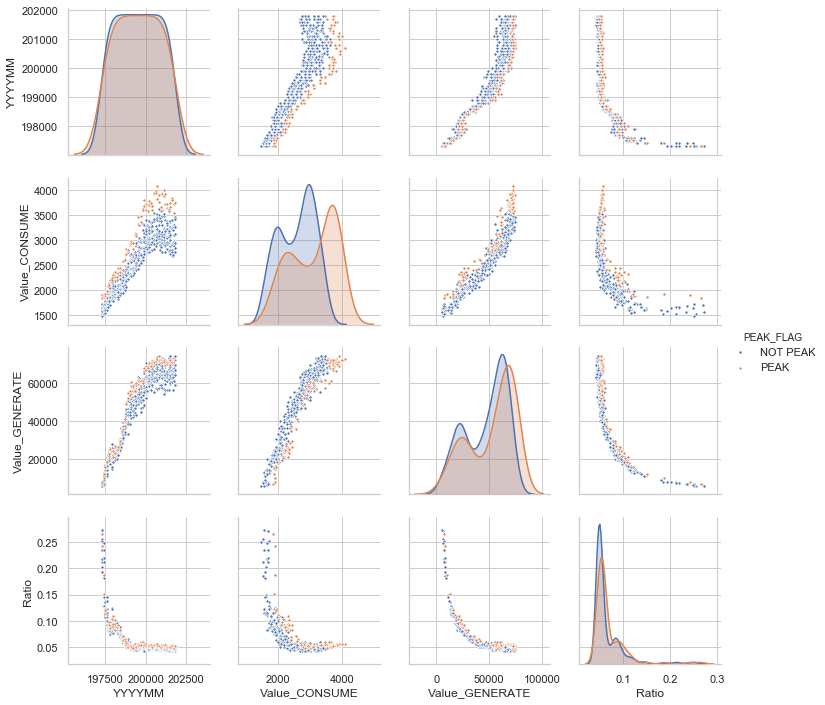

In [47]:
# Etiquetar meses de verano
customized_df = merged_df.copy()
customized_df['PEAK_FLAG'] = customized_df['YYYYMM'].apply(lambda x: 'PEAK' if str(x)[-2:] in ['07','08'] else 'NOT PEAK')

sns.pairplot(customized_df, hue='PEAK_FLAG', x_vars=['YYYYMM','Value_CONSUME','Value_GENERATE','Ratio'], y_vars=['YYYYMM','Value_CONSUME','Value_GENERATE','Ratio'], plot_kws={'s':10});

Este gráfico toma cada columna numérica y crea un diagrama de dispersión contra las otras numéricas. 

Los meses pico tienen distribuciones diferentes en efecto.

## ¿Son el consumo y la generación de los meses pico consistentes a lo largo del tiempo?

Analicemos mes a mes a través del tiempo para ver si los picos de patrones cíclicos son estables a través del tiempo.

```seaborn``` ofrece el método **heatmap**

In [48]:
# Extraer el año para usar en el heatmap
customized_df['YYYY'] = customized_df['YYYYMM'].apply(lambda x: str(x)[:-2])

# Crear tabla dinámica para visualizarlo fácil
pivot_elec_df = customized_df.pivot('MM','YYYY','Value_GENERATE')
pivot_ener_df = customized_df.pivot('MM','YYYY','Value_CONSUME')

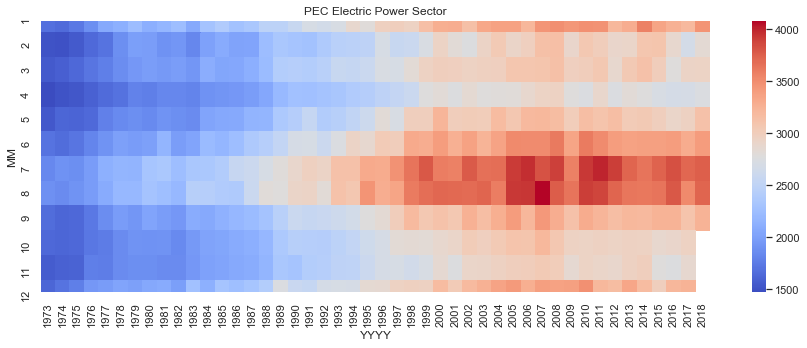

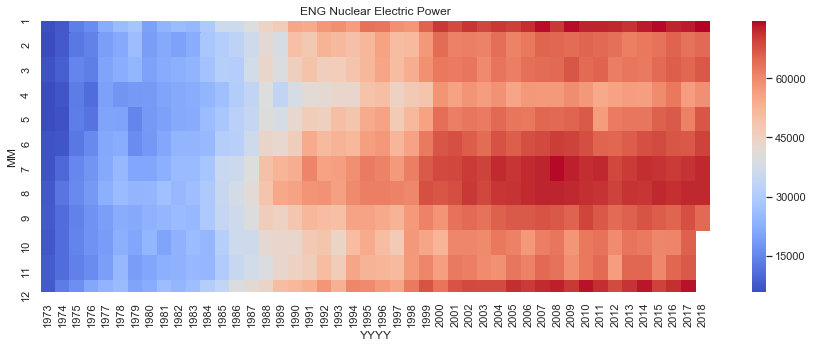

In [49]:
# Mapa de calor del consumo por mes y año
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(pivot_ener_df, cmap="coolwarm", ax=ax);
ax.set_title('PEC Electric Power Sector');

# Mapa de calor de generación de energía por mes y año
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(pivot_elec_df, cmap="coolwarm", ax=ax);
ax.set_title('ENG Nuclear Electric Power');

Es evidente el incremento en consumo y generación durante los meses pico desde 1990. Antes de eses año no es tan marcado. Esto puede explicarse por el incremento en el uso de unidades de enfriamiento

En general, la energía consumida y la generación han incrementado, evidenciado por el movimiento de colores azul a rojo en ambos gráficos. Esto es de esperarse.

## ¿Qué sectores consumen más energía?

```seaborn``` fácilmente permite graficar por categoría

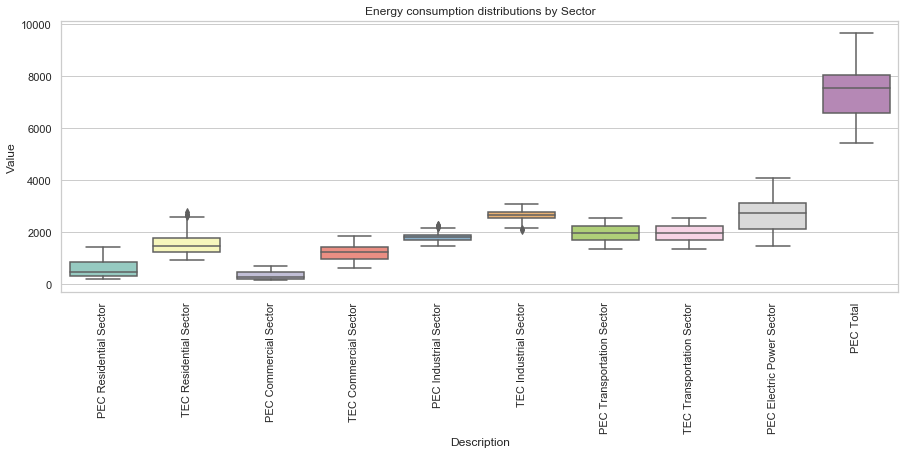

In [50]:
# Gráfico de caja por categoría
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x="Description", y="Value", data=clean_energy_df, palette="Set3", ax=ax)
plt.xticks(rotation=90);
plt.title('Energy consumption distributions by Sector');

Sector eléctrico consume más, como es de esperarse.

## Una vista un poco más granular del consumon por sector
```stripplot()``` en ```seaborn``` crea una serie de diagramas de dispersión de 1 dimensión por cada categoría, todos compartiendo el mismo eje-y

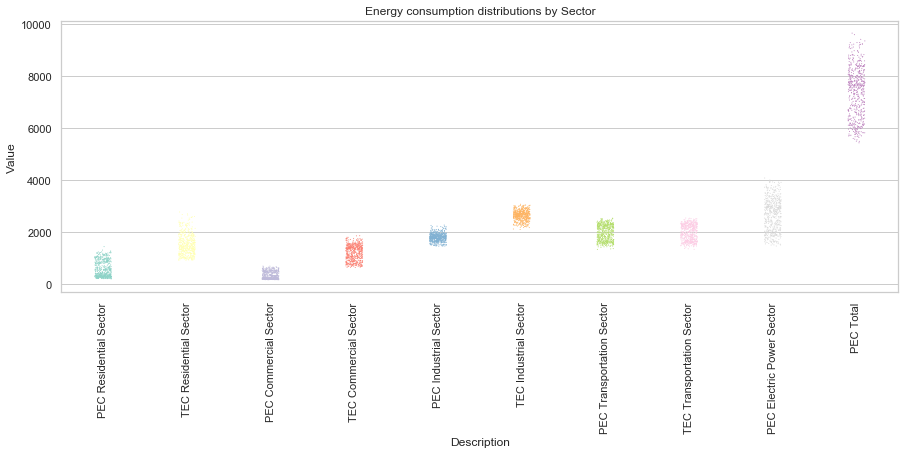

In [51]:
# Gráfico granular
fig, ax = plt.subplots(figsize=(15,5))
m = sns.stripplot(x="Description", y="Value", data=clean_energy_df, palette="Set3", s=1, ax=ax)
plt.xticks(rotation=90);
plt.title('Energy consumption distributions by Sector');

## Conclusiones

Descubrimos que el pico del consumo de energía se da en los meses de verano.

El sector eléctrico parece ser quien conduce de manera marginal la demanda, esto quiere decir que la mejor decisión podría ser dedicar una gran cantidad de recursos de la plana de energía a este sector.

## Aprendizajes

Cubrimos varias técnicas de visualización que ofrece Python tanto con matplotlib como con seaborn, y se aprendió a interpretar los resultados de estos gráficos.